# DECISION MODELLING - PFIZER PROJECT
Group Members : Maria Kontaratou Manon Lagarde Henri Langois

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from ortools.linear_solver import pywraplp



### LOAD DATA: 

In [ ]:
# Load the data from the "brick-brick" sheet :
data_df = pd.read_excel("distances.xlsx", sheet_name="brick-brick")
Dij_df = data_df.iloc[1:23, 2:24]
Dij = Dij_df.values.tolist()

indexes_df = pd.read_excel("indexValues.xlsx", usecols="B", nrows=22, header=None)
Wi = indexes_df.iloc[:, 0].tolist()  

# Initialize the solver with SCIP :
solver = pywraplp.Solver.CreateSolver('SCIP')
if not solver:
    raise ValueError("SCIP solver is not available.")

# Define problem dimensions based on data :
num_bricks, num_sr = len(Wi), 4
X = [[solver.BoolVar(f'X[{i},{j}]') for j in range(num_sr)] for i in range(num_bricks)]

# Define fixed "center" indices for each SR (+1 because its a list) :
center_indices = [3, 13, 15, 21]



### INITIAL ASSIGNMENT : 

Current Distributions of Bricks to the SRs : 
| SR | Center Brick | Bricks Assigned                   |
|----|--------------|-----------------------------------|
| 1  | 4            | 4, 5, 6, 7, 8, 15                |
| 2  | 14           | 10, 11, 12, 13, 14               |
| 3  | 16           | 9, 16, 17, 18                    |
| 4  | 22           | 1, 2, 3, 19, 20, 21, 22          |

**Table 1. Current Structure of Sales Territories**


In [44]:

# Define the current assignment of bricks to SRs
assignments = {
    0: [3, 4, 5, 6, 7, 8, 14],  # SR 1: center brick 4
    1: [9, 10, 11, 12, 13, 14],  # SR 2: center brick 14
    2: [8, 15, 16, 17],          # SR 3: center brick 16
    3: [0, 1, 2, 18, 19, 20, 21] # SR 4: center brick 22
}

# Calculate the total distance and workload for each SR
total_distance = [0] * num_sr
total_workload = [0] * num_sr

for sr in range(num_sr):
    center_brick = center_indices[sr]
    
    # For each brick assigned to this SR, compute the distance and workload
    for brick in assignments[sr]:
        # Distance traveled for this brick
        total_distance[sr] += Dij[brick][center_brick]
        
        # Workload for this brick
        total_workload[sr] += Wi[brick]

# Output results
for sr in range(num_sr):
    print(f"SR{sr+1}:")
    print(f"  Total Distance Traveled: {total_distance[sr]}")
    print(f"  Total Workload: {total_workload[sr]}")

print(f"\nTotal Distance Travelled : {sum(total_distance)}")

SR1:
  Total Distance Traveled: 23.1
  Total Workload: 1.1623
SR2:
  Total Distance Traveled: 35.63
  Total Workload: 1.7491999999999999
SR3:
  Total Distance Traveled: 9.989999999999998
  Total Workload: 0.7047999999999999
SR4:
  Total Distance Traveled: 124.74000000000001
  Total Workload: 1.0068000000000001

Total Distance Travelled : 193.46


### OUR MODEL : 

##### Variables : 
- $x_{ij}$ : Binary variable indicating if brick $i$ is assigned to SR $j$ (1 if assigned, 0 otherwise)
- $d_{ij}$ : Distance of brick $i$ from the center brick of SR $j$
- $w_i$ : workload index for brick $i$

##### Constraints : 

[1] $x_{ij} \in \{0, 1\} \quad \forall i, j$

[2] Each brick $i$ is assigned to exactly one SR:
$$
\sum_{j} x_{ij} = 1 \quad \forall i
$$

[3] Workload Balance : 
$$
0.8 \leq \sum_{i} w_i \cdot x_{ij} \leq 1.2 \quad \forall j
$$

##### Objective Function : 

[1] Minimize the Total Travel Distance : 
$$
\text{Minimize } D = \sum_{j} \sum_{i} d_{ij} \cdot x_{ij}
$$

[2] Minimize the Disruption : 
$$
\text{Minimize } T = \sum_{j} \sum_{i} w_i \cdot |x_{ij} - x_{ij}^{\text{initial}}|
$$

where $x_{ij}^{\text{initial}}$ is the initial assignment 



### MINIMIZE DISTANCES 

[1] Minimize the Total Travel Distance : 
$$
\text{Minimize } D = \sum_{j} \sum_{i} d_{ij} \cdot x_{ij}
$$

In [45]:
# OUR CONSTRAINTS :
# Workload Constraints: Each SR’s workload should be balanced between 0.8 and 1.2
for j in range(num_sr):
    workload_expr = solver.Sum(Wi[i] * X[i][j] for i in range(num_bricks))
    solver.Add(workload_expr >= 0.8)
    solver.Add(workload_expr <= 1.2)

# Assignment Constraints: Each brick must be assigned to exactly one SR
for i in range(num_bricks):
    solver.Add(solver.Sum(X[i][j] for j in range(num_sr)) == 1)

In [46]:
''' MINIMIZE DISTANCES '''

# OUR OBJECTIVE : Minimize Distance based on fixed centers
distance_expr = solver.Sum(
    X[i][j] * Dij[center_indices[j]][i] for i in range(num_bricks) for j in range(num_sr)
)

solver.Minimize(distance_expr)
status = solver.Solve()

if status == pywraplp.Solver.OPTIMAL:
    print("Optimal solution found with SCIP!")
    
    # Retrieve the solution and workload for each SR
    solution = [[X[i][j].solution_value() for j in range(num_sr)] for i in range(num_bricks)]
    Xij = pd.DataFrame(data=solution, index=range(num_bricks), columns=['SR1', 'SR2', 'SR3', 'SR4'])
    
    # Calculate and print total workload for each SR
    result_workload = np.array(solution) * np.array(Wi).reshape(-1, 1)
    for j in range(num_sr):
        total_workload_sr = np.sum(result_workload[:, j])
        print(f"The workload of SR{j+1} is:", total_workload_sr)
    
    # Calculate and print minimum total distance
    min_total_distance = solver.Objective().Value()
    print("The minimum total distance is:", min_total_distance)
    
    
elif status == pywraplp.Solver.INFEASIBLE:
    print("SCIP reports the problem as infeasible.")
else:
    print("No solution found with SCIP. Status code:", status)

Optimal solution found with SCIP!
The workload of SR1 is: 1.0375999999999999
The workload of SR2 is: 1.0447
The workload of SR3 is: 1.1148999999999998
The workload of SR4 is: 0.8028000000000001
The minimum total distance is: 154.62


### MINIMIZE DISRUPTION


[2] Minimize the Disruption : 
$$
\text{Minimize } T = \sum_{j} \sum_{i} w_i \cdot \left( x_{ij} - 2 \cdot x_{ij} \cdot x_{ij}^{\text{initial}} + x_{ij}^{\text{initial}} \right)
$$

where $x_{ij}^{\text{initial}}$ is the initial assignment 

In [47]:
# INITIALIZATION : 

# Use the initial assignment (x_initial) provided (extended for 5 service regions)
x_initial = [
    [0.0, 0.0, 0.0, 1.0, 0.0],
    [0.0, 0.0, 0.0, 1.0, 0.0],
    [0.0, 0.0, 0.0, 1.0, 0.0],
    [1.0, 0.0, 0.0, 0.0, 0.0],
    [1.0, 0.0, 0.0, 0.0, 0.0],
    [1.0, 0.0, 0.0, 0.0, 0.0],
    [1.0, 0.0, 0.0, 0.0, 0.0],
    [1.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, 0.0, 0.0],
    [1.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 1.0, 0.0],
    [0.0, 0.0, 0.0, 1.0, 0.0],
    [0.0, 0.0, 0.0, 1.0, 0.0],
    [0.0, 0.0, 0.0, 1.0, 0.0]
]

In [48]:
''' MINIMIZE DISRUPTION '''

# Disruption Objective using squared terms
obj_disrupt = solver.Sum(
    Wi[i] * (X[i][j] - 2 * X[i][j] * x_initial[i][j] + x_initial[i][j])
    for i in range(num_bricks) for j in range(num_sr)
)

solver.Minimize(obj_disrupt)
status = solver.Solve()

# Output results
if status == pywraplp.Solver.OPTIMAL:
    print("Optimal solution found!")
    
    # Retrieve the solution and workload for each SR
    solution = [[X[i][j].solution_value() for j in range(num_sr)] for i in range(num_bricks)]
    Xij = pd.DataFrame(data=solution, index=range(num_bricks), columns=['SR1', 'SR2', 'SR3', 'SR4'])
    
    # Calculate and print total workload for each SR
    result_workload = np.array(solution) * np.array(Wi).reshape(-1, 1)
    for j in range(num_sr):
        total_workload_sr = np.sum(result_workload[:, j])
        print(f"The workload of SR{j+1} is:", total_workload_sr)
    
    # Calculate and print the minimum total disruption
    min_total_disruption = solver.Objective().Value()
    print("The minimum disruption is:", min_total_disruption)

    # Calculate total distance traveled
    total_distance = 0
    for i in range(num_bricks):
        for j in range(num_sr):
            total_distance += solution[i][j] * Dij[i][center_indices[j]]
    
    print("The total distance traveled by all SRs is:", total_distance)

    
elif status == pywraplp.Solver.INFEASIBLE:
    print("The problem is infeasible.")
else:
    print("No solution found with SCIP. Status code:", status)


Optimal solution found!
The workload of SR1 is: 0.9506999999999999
The workload of SR2 is: 1.1681
The workload of SR3 is: 0.8743999999999998
The workload of SR4 is: 1.0068000000000001
The minimum disruption is: 0.33919999999999995
The total distance traveled by all SRs is: 188.89000000000004


### MINIMIZE DISTANCE AND DISRUPTION

Overall Objective : 


$$
\text{Minimize } Z = w_D \cdot \left( \sum_{i=1}^{\text{num\_bricks}} \sum_{j=1}^{\text{num\_sr}} x_{ij} \cdot d_{ij} \right) + w_T \cdot \left( \sum_{i=1}^{\text{num\_bricks}} \sum_{j=1}^{\text{num\_sr}} w_i \cdot \left( x_{ij} - 2 \cdot x_{ij} \cdot x_{ij}^{\text{initial}} + x_{ij}^{\text{initial}} \right) \right)
$$


In [49]:
''' Minimize both distance and disruption'''

# Set weights for objectives
distance_weight = 1.0  # Adjust to prioritize distance
disruption_weight = 1.0  # Adjust to prioritize disruption


# Distance Objective
distance_expr = solver.Sum(
    X[i][j] * Dij[i][center_indices[j]]
    for i in range(num_bricks) for j in range(num_sr)
)

# Disruption Objective using squared terms
obj_disrupt = solver.Sum(
    Wi[i] * (X[i][j] - 2 * X[i][j] * x_initial[i][j] + x_initial[i][j])
    for i in range(num_bricks) for j in range(num_sr)
)

# Combine objectives with weights and solve
combined_obj = distance_weight * distance_expr + disruption_weight * obj_disrupt
solver.Minimize(combined_obj)
status = solver.Solve()


if status == pywraplp.Solver.OPTIMAL:
    print("Optimal solution found!")
    
    # Retrieve the solution and workload for each SR
    solution = [[X[i][j].solution_value() for j in range(num_sr)] for i in range(num_bricks)]
    Xij = pd.DataFrame(data=solution, index=range(num_bricks), columns=['SR1', 'SR2', 'SR3', 'SR4'])
    
    # Calculate and print total workload for each SR
    result_workload = np.array(solution) * np.array(Wi).reshape(-1, 1)
    for j in range(num_sr):
        total_workload_sr = np.sum(result_workload[:, j])
        print(f"The workload of SR{j+1} is: {total_workload_sr:.4f}")
    
    # Calculate and print total distance
    total_distance = sum(
        solution[i][j] * Dij[i][center_indices[j]]
        for i in range(num_bricks) for j in range(num_sr)
    )
    print(f"The minimum total distance is: {total_distance:.4f}")
    
    # Calculate and print total disruption
    total_disruption = sum(
        Wi[i] * (solution[i][j] - 2 * solution[i][j] * x_initial[i][j] + x_initial[i][j])
        for i in range(num_bricks) for j in range(num_sr)
    )
    print(f"The minimum total disruption is: {total_disruption:.4f}")
    
    
elif status == pywraplp.Solver.INFEASIBLE:
    print("The problem is infeasible.")
elif status == pywraplp.Solver.UNBOUNDED:
    print("The problem is unbounded.")
else:
    print("No solution found. Status code:", status)


Optimal solution found!
The workload of SR1 is: 0.9548
The workload of SR2 is: 1.1275
The workload of SR3 is: 1.1149
The workload of SR4 is: 0.8028
The minimum total distance is: 154.6400
The minimum total disruption is: 2.2454


### TRADE_OFF DISTANCES VS DISRUPTION :

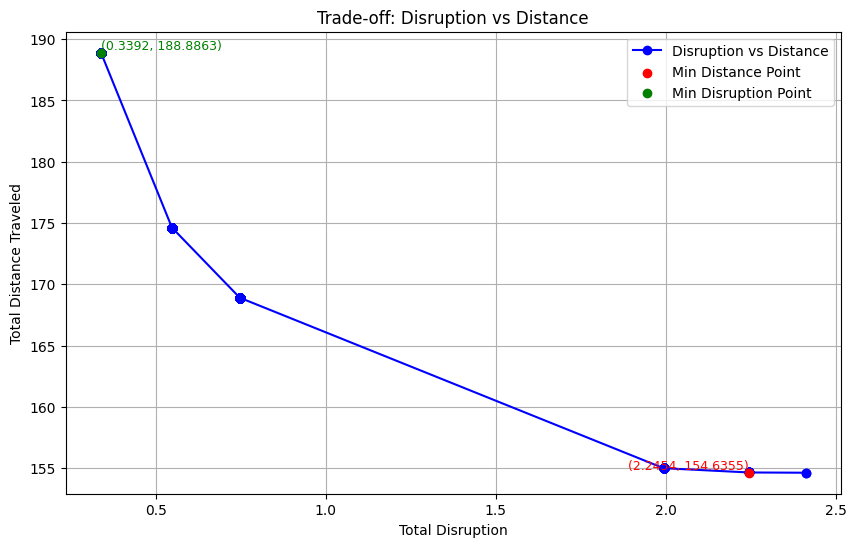

In [50]:
# Initialize lists to store results
distances = []
disruptions = []

# Define a range of weights for disruption
disruption_weights = np.arange(0, 170.1, 0.1)  # Range: 0 to 170 with step 0.1

# Points to highlight - Minimize distance and minimize disruption
highlight_red_disruption = 2.2454
highlight_red_distance = 154.6355

highlight_green_disruption = 0.3392
highlight_green_distance = 188.8863

for disruption_weight in disruption_weights:
    # Reset solver for each iteration
    solver = pywraplp.Solver.CreateSolver('SCIP')
    if not solver:
        raise ValueError("SCIP solver is not available.")

    # Decision variables
    X = [[solver.BoolVar(f'X[{i},{j}]') for j in range(num_sr)] for i in range(num_bricks)]

    # Workload Constraints
    for j in range(num_sr):
        workload_expr = solver.Sum(Wi[i] * X[i][j] for i in range(num_bricks))
        solver.Add(workload_expr >= 0.8)
        solver.Add(workload_expr <= 1.2)

    # Assignment Constraints
    for i in range(num_bricks):
        solver.Add(solver.Sum(X[i][j] for j in range(num_sr)) == 1)

    # Distance Objective
    distance_expr = solver.Sum(
        X[i][j] * Dij[i][center_indices[j]]
        for i in range(num_bricks) for j in range(num_sr)
    )

    # Disruption Objective
    disruption_expr = solver.Sum(
        Wi[i] * (X[i][j] - 2 * X[i][j] * x_initial[i][j] + x_initial[i][j])
        for i in range(num_bricks) for j in range(num_sr)
    )

    # Combine objectives with weights
    combined_obj = distance_weight * distance_expr + disruption_weight * disruption_expr
    solver.Minimize(combined_obj)
    status = solver.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        # Calculate total distance
        total_distance = sum(
            X[i][j].solution_value() * Dij[i][center_indices[j]]
            for i in range(num_bricks) for j in range(num_sr)
        )

        # Calculate total disruption
        total_disruption = sum(
            Wi[i] * (X[i][j].solution_value() - 2 * X[i][j].solution_value() * x_initial[i][j] + x_initial[i][j])
            for i in range(num_bricks) for j in range(num_sr)
        )

        # Append results
        distances.append(total_distance)
        disruptions.append(total_disruption)
    else:
        print(f"No optimal solution found for disruption weight {disruption_weight}.")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(disruptions, distances, label="Disruption vs Distance", color="blue", marker="o")

# Highlight the specific points
plt.scatter([highlight_red_disruption], [highlight_red_distance], color="red", label="Min Distance Point", zorder=5)
plt.text(
    highlight_red_disruption, highlight_red_distance,
    f"({highlight_red_disruption:.4f}, {highlight_red_distance:.4f})",
    color="red", fontsize=9, verticalalignment="bottom", horizontalalignment="right"
)

plt.scatter([highlight_green_disruption], [highlight_green_distance], color="green", label="Min Disruption Point", zorder=5)
plt.text(
    highlight_green_disruption, highlight_green_distance,
    f"({highlight_green_disruption:.4f}, {highlight_green_distance:.4f})",
    color="green", fontsize=9, verticalalignment="bottom", horizontalalignment="left"
)

# Set plot labels and title
plt.xlabel("Total Disruption")
plt.ylabel("Total Distance Traveled")
plt.title("Trade-off: Disruption vs Distance")
plt.grid(True)
plt.legend()
plt.show()


### FLEXIBLE CONSTRAINTS :

This function optimizes the assignment of bricks to sales representatives (SRs) by minimizing both the total travel distance and disruption in the assignments, while considering multiple workload bounds for each SR.

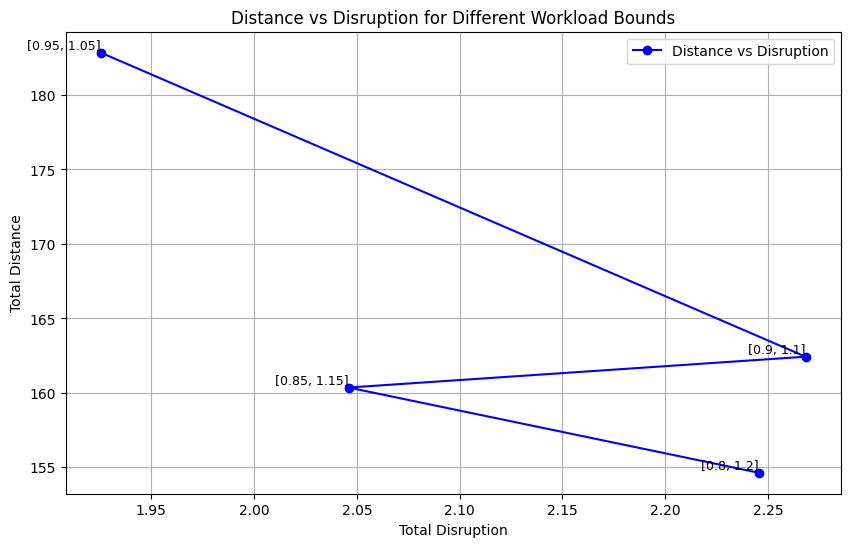

Raw Results:
Workload Bounds  Total Distance  Total Disruption
     [0.8, 1.2]          154.64            2.2454
   [0.85, 1.15]          160.36            2.0460
     [0.9, 1.1]          162.43            2.2682
   [0.95, 1.05]          182.84            1.9256


In [51]:
def minimize_distance_and_disruption_multiple_bounds(workload_bounds, x_initial, num_bricks, num_sr, Wi, Dij, center_indices):
    results = []

    for lower, upper in workload_bounds:
        # Initialize a solver instance
        solver = pywraplp.Solver.CreateSolver('SCIP')
        if not solver:
            print("Solver not available.")
            continue

        # Define decision variables
        X = [[solver.BoolVar(f"X[{i},{j}]") for j in range(num_sr)] for i in range(num_bricks)]

        # Apply workload constraints
        for j in range(num_sr):
            workload_expr = solver.Sum(Wi[i] * X[i][j] for i in range(num_bricks))
            solver.Add(workload_expr >= lower)
            solver.Add(workload_expr <= upper)

        # Apply assignment constraints
        for i in range(num_bricks):
            solver.Add(solver.Sum(X[i][j] for j in range(num_sr)) == 1)

        # Define the distance objective
        distance_expr = solver.Sum(
            X[i][j] * Dij[i][center_indices[j]]
            for i in range(num_bricks) for j in range(num_sr)
        )

        # Define the disruption objective using squared terms
        obj_disrupt = solver.Sum(
            Wi[i] * (X[i][j] - 2 * X[i][j] * x_initial[i][j] + x_initial[i][j])
            for i in range(num_bricks) for j in range(num_sr)
        )

        # Combine objectives with weights
        combined_obj = distance_expr + obj_disrupt
        solver.Minimize(combined_obj)

        # Solve the problem
        status = solver.Solve()

        if status == pywraplp.Solver.OPTIMAL:
            # Retrieve total distance and disruption
            total_distance = sum(
                X[i][j].solution_value() * Dij[i][center_indices[j]]
                for i in range(num_bricks) for j in range(num_sr)
            )
            total_disruption = sum(
                Wi[i] * (X[i][j].solution_value() - 2 * X[i][j].solution_value() * x_initial[i][j] + x_initial[i][j])
                for i in range(num_bricks) for j in range(num_sr)
            )
            results.append((f"[{lower}, {upper}]", total_distance, total_disruption))
        else:
            results.append((f"[{lower}, {upper}]", None, None))

    # Create a DataFrame of results
    results_df = pd.DataFrame(results, columns=["Workload Bounds", "Total Distance", "Total Disruption"])
    return results_df

# Define workload constraints to analyze
workload_bounds = [
    (0.8, 1.2),
    (0.85, 1.15),
    (0.9, 1.1),
    (0.95, 1.05)
]

# Call the function
results_df = minimize_distance_and_disruption_multiple_bounds(workload_bounds, x_initial, num_bricks, num_sr, Wi, Dij, center_indices)

# Plot raw distance vs. disruption
plt.figure(figsize=(10, 6))
plt.plot(
    results_df["Total Disruption"],
    results_df["Total Distance"],
    marker="o", color="blue", label="Distance vs Disruption"
)
plt.xlabel("Total Disruption")
plt.ylabel("Total Distance")
plt.title("Distance vs Disruption for Different Workload Bounds")
plt.grid(True)

# Annotate points with workload bounds
for i, row in results_df.iterrows():
    plt.annotate(
        row["Workload Bounds"],
        (row["Total Disruption"], row["Total Distance"]),
        fontsize=9, ha="right", va="bottom"
    )

plt.legend()
plt.show()

# Display raw results
print("Raw Results:")
print(results_df.to_string(index=False))


### ADDITIVE MODEL :   


Combine multiple objectives (e.g., disruption and travel distance) into a weighted additive score and different bounds : 

In this function, we are solving an optimization problem that minimizes both distance and disruption between initial and current assignments, while adjusting the workload bounds for each sales representative (SR). By assigning higher weights to distance and smaller weights to disruption, we prioritize minimizing travel distances, but still account for disruption when there are ties in the distance objective, allowing us to analyze trade-offs between the two objectives for different workload constraints.

The weighted score is then calculated for each set of workload bounds, providing a trade-off analysis between distance and disruption for different constraints on SR workloads.

#### Weighted Score Formula

The **weighted score** is computed as follows:

$$
\text{Weighted Score} = w_D \cdot \text{Total Distance} + w_T \cdot \text{Total Disruption}
$$


In [52]:

def solve_with_weighted_objective(workload_bounds, disruption_weight=0.1, distance_weight=1.0):
    results = []

    for lower, upper in workload_bounds:
        # Initialize a solver instance
        solver = pywraplp.Solver.CreateSolver('SCIP')
        if not solver:
            print("Solver not available.")
            continue

        # Define decision variables
        X = [[solver.BoolVar(f"X[{i},{j}]") for j in range(num_sr)] for i in range(num_bricks)]

        # Apply workload constraints
        for j in range(num_sr):
            workload_expr = solver.Sum(Wi[i] * X[i][j] for i in range(num_bricks))
            solver.Add(workload_expr >= lower)
            solver.Add(workload_expr <= upper)

        # Apply assignment constraints
        for i in range(num_bricks):
            solver.Add(solver.Sum(X[i][j] for j in range(num_sr)) == 1)

        # Define the distance objective
        distance_expr = solver.Sum(
            X[i][j] * Dij[i][center_indices[j]]
            for i in range(num_bricks) for j in range(num_sr)
        )

        # Define the disruption objective using squared terms
        obj_disrupt = solver.Sum(
            Wi[i] * (X[i][j] - 2 * X[i][j] * x_initial[i][j] + x_initial[i][j])
            for i in range(num_bricks) for j in range(num_sr)
        )

        # Combine objectives with weights
        combined_obj = distance_weight * distance_expr + disruption_weight * obj_disrupt
        solver.Minimize(combined_obj)

        # Solve the problem
        status = solver.Solve()

        if status == pywraplp.Solver.OPTIMAL:
            # Retrieve total distance and disruption
            total_distance = sum(
                X[i][j].solution_value() * Dij[i][center_indices[j]]
                for i in range(num_bricks) for j in range(num_sr)
            )
            total_disruption = sum(
                Wi[i] * (X[i][j].solution_value() - 2 * X[i][j].solution_value() * x_initial[i][j] + x_initial[i][j])
                for i in range(num_bricks) for j in range(num_sr)
            )
            weighted_score = distance_weight * total_distance + disruption_weight * total_disruption
            results.append((f"[{lower}, {upper}]", total_distance, total_disruption, weighted_score))
        else:
            results.append((f"[{lower}, {upper}]", None, None, None))

    # Create a DataFrame of results
    results_df = pd.DataFrame(results, columns=["Workload Bounds", "Total Distance", "Total Disruption", "Weighted Score"])
    return results_df

# Define workload constraints to analyze
workload_bounds = [
    (0.8, 1.2),
    (0.85, 1.15),
    (0.9, 1.1),
    (0.95, 1.05)
]

# Call the function to solve with a weighted objective
weighted_results_df = solve_with_weighted_objective(
    workload_bounds,
    disruption_weight=0.1,  # Small weight for disruption
    distance_weight=1.0    # Higher weight for distance
)
# Display results
# Display results as a table
print("Weighted Objective Analysis for Multiple Workload Bounds:")
print(weighted_results_df.to_string(index=False)) 

Weighted Objective Analysis for Multiple Workload Bounds:
Workload Bounds  Total Distance  Total Disruption  Weighted Score
     [0.8, 1.2]          154.62            2.4110       154.86110
   [0.85, 1.15]          160.34            2.2116       160.56116
     [0.9, 1.1]          162.43            2.2682       162.65682
   [0.95, 1.05]          182.84            1.9256       183.03256


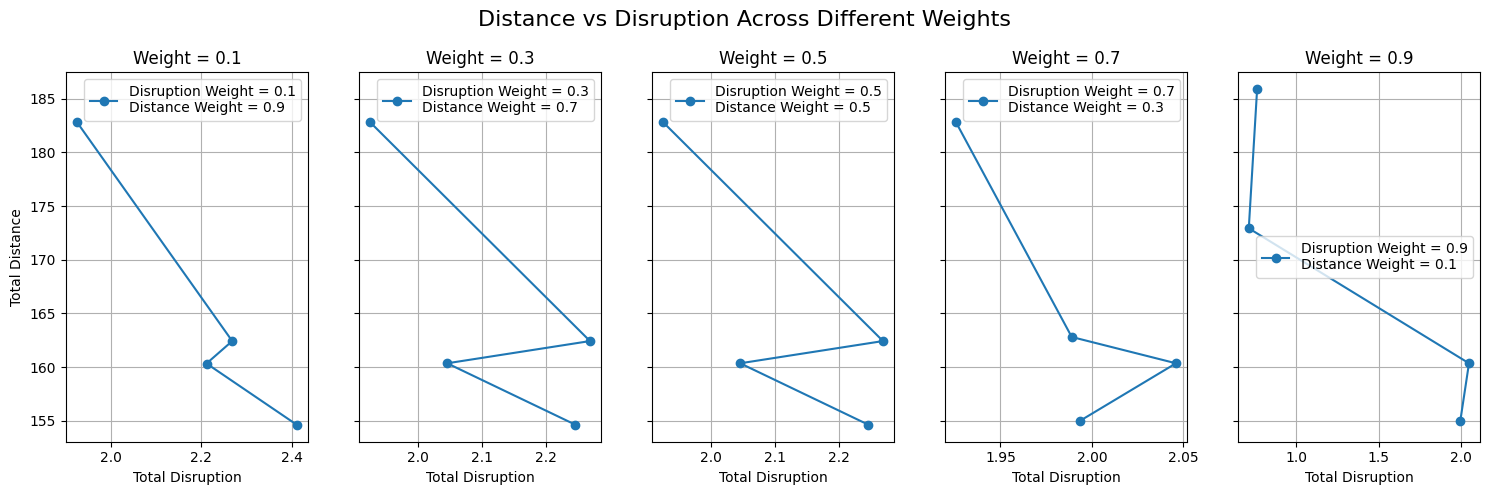

Results for Disruption Weight = 0.1, Distance Weight = 0.9
Workload Bounds  Total Distance  Total Disruption  Weighted Score
     [0.8, 1.2]          154.62            2.4110       139.39910
   [0.85, 1.15]          160.34            2.2116       144.52716
     [0.9, 1.1]          162.43            2.2682       146.41382
   [0.95, 1.05]          182.84            1.9256       164.74856

Results for Disruption Weight = 0.3, Distance Weight = 0.7
Workload Bounds  Total Distance  Total Disruption  Weighted Score
     [0.8, 1.2]          154.64            2.2454       108.92162
   [0.85, 1.15]          160.36            2.0460       112.86580
     [0.9, 1.1]          162.43            2.2682       114.38146
   [0.95, 1.05]          182.84            1.9256       128.56568

Results for Disruption Weight = 0.5, Distance Weight = 0.5
Workload Bounds  Total Distance  Total Disruption  Weighted Score
     [0.8, 1.2]          154.64            2.2454         78.4427
   [0.85, 1.15]          160.

In [53]:

def solve_with_weighted_objective(workload_bounds, disruption_weight=0.1, distance_weight=1.0):
    results = []

    for lower, upper in workload_bounds:
        # Initialize a solver instance
        solver = pywraplp.Solver.CreateSolver('SCIP')
        if not solver:
            print("Solver not available.")
            continue

        # Define decision variables
        X = [[solver.BoolVar(f"X[{i},{j}]") for j in range(num_sr)] for i in range(num_bricks)]

        # Apply workload constraints
        for j in range(num_sr):
            workload_expr = solver.Sum(Wi[i] * X[i][j] for i in range(num_bricks))
            solver.Add(workload_expr >= lower)
            solver.Add(workload_expr <= upper)

        # Apply assignment constraints
        for i in range(num_bricks):
            solver.Add(solver.Sum(X[i][j] for j in range(num_sr)) == 1)

        # Define the distance objective
        distance_expr = solver.Sum(
            X[i][j] * Dij[i][center_indices[j]]
            for i in range(num_bricks) for j in range(num_sr)
        )

        # Define the disruption objective using squared terms
        obj_disrupt = solver.Sum(
            Wi[i] * (X[i][j] - 2 * X[i][j] * x_initial[i][j] + x_initial[i][j])
            for i in range(num_bricks) for j in range(num_sr)
        )

        # Combine objectives with weights
        combined_obj = distance_weight * distance_expr + disruption_weight * obj_disrupt
        solver.Minimize(combined_obj)

        # Solve the problem
        status = solver.Solve()

        if status == pywraplp.Solver.OPTIMAL:
            # Retrieve total distance and disruption
            total_distance = sum(
                X[i][j].solution_value() * Dij[i][center_indices[j]]
                for i in range(num_bricks) for j in range(num_sr)
            )
            total_disruption = sum(
                Wi[i] * (X[i][j].solution_value() - 2 * X[i][j].solution_value() * x_initial[i][j] + x_initial[i][j])
                for i in range(num_bricks) for j in range(num_sr)
            )
            weighted_score = distance_weight * total_distance + disruption_weight * total_disruption
            results.append((f"[{lower}, {upper}]", total_distance, total_disruption, weighted_score))
        else:
            results.append((f"[{lower}, {upper}]", None, None, None))

    # Create a DataFrame of results
    results_df = pd.DataFrame(results, columns=["Workload Bounds", "Total Distance", "Total Disruption", "Weighted Score"])
    return results_df


# Define workload constraints to analyze
workload_bounds = [
    (0.8, 1.2),
    (0.85, 1.15),
    (0.9, 1.1),
    (0.95, 1.05)
]

# Analyze multiple weights
weight_ranges = [0.1, 0.3, 0.5, 0.7, 0.9]
all_results = []

for weight in weight_ranges:
    weighted_results_df = solve_with_weighted_objective(
        workload_bounds,
        disruption_weight=weight,
        distance_weight=1 - weight  # Complementary weights
    )
    all_results.append((weight, weighted_results_df))

# Plot subplots for each weight
num_plots = len(all_results)
fig, axes = plt.subplots(1, num_plots, figsize=(15, 5), sharey=True)

for ax, (weight, df) in zip(axes, all_results):
    ax.plot(
        df["Total Disruption"],
        df["Total Distance"],
        marker="o",
        label=f"Disruption Weight = {weight:.1f}\nDistance Weight = {1-weight:.1f}"
    )
    ax.set_xlabel("Total Disruption")
    ax.set_title(f"Weight = {weight:.1f}")
    ax.grid(True)
    ax.legend()

axes[0].set_ylabel("Total Distance")  # Add shared y-label
fig.suptitle("Distance vs Disruption Across Different Weights", fontsize=16)
plt.tight_layout()
plt.show()

# Print the weighted results for reference
for weight, df in all_results:
    print(f"Results for Disruption Weight = {weight:.1f}, Distance Weight = {1-weight:.1f}")
    print(df.to_string(index=False))
    print()


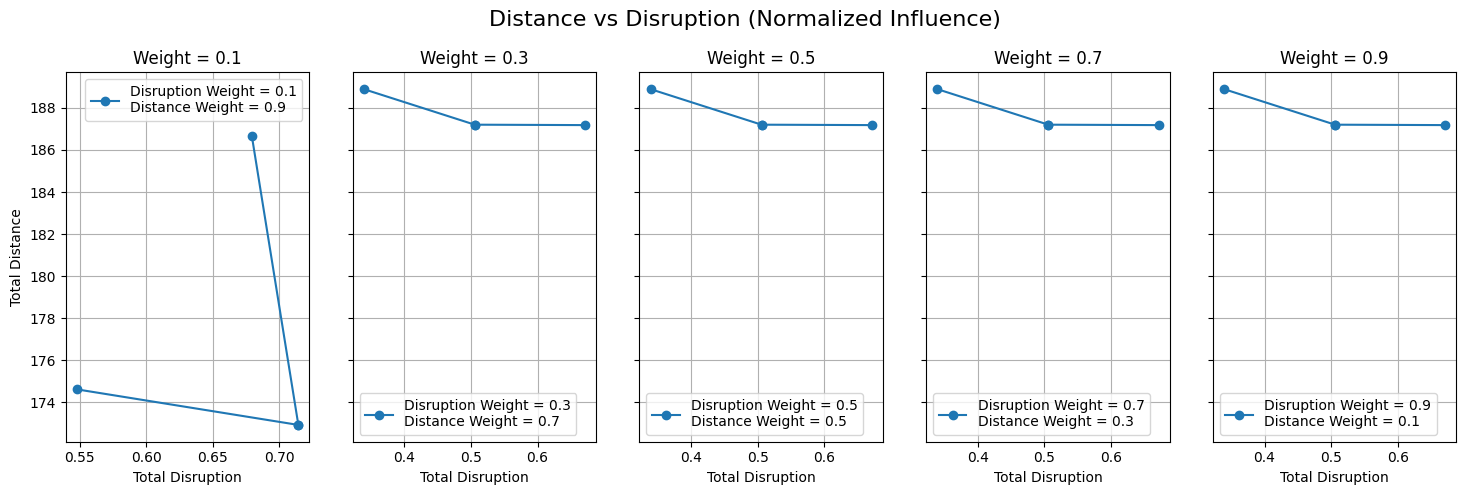

Results for Disruption Weight = 0.1, Distance Weight = 0.9
Workload Bounds  Total Distance  Total Disruption  Weighted Score
     [0.8, 1.2]          174.62            0.5478        0.115371
   [0.85, 1.15]          172.93            0.7144        0.118552
     [0.9, 1.1]          172.93            0.7144        0.118552
   [0.95, 1.05]          186.66            0.6794        0.125671

Results for Disruption Weight = 0.3, Distance Weight = 0.7
Workload Bounds  Total Distance  Total Disruption  Weighted Score
     [0.8, 1.2]          188.89            0.3392        0.110984
   [0.85, 1.15]          187.20            0.5058        0.122713
     [0.9, 1.1]          187.20            0.5058        0.122713
   [0.95, 1.05]          187.18            0.6714        0.135124

Results for Disruption Weight = 0.5, Distance Weight = 0.5
Workload Bounds  Total Distance  Total Disruption  Weighted Score
     [0.8, 1.2]          188.89            0.3392        0.103503
   [0.85, 1.15]          187.

In [ ]:
def solve_with_normalized_objective(workload_bounds, disruption_weight=0.1, distance_weight=1.0):
    # Precompute maximum possible values for normalization
    max_distance = sum(Dij[i][center_indices[j]] for i in range(num_bricks) for j in range(num_sr))
    max_disruption = sum(Wi[i] * x_initial[i][j] for i in range(num_bricks) for j in range(num_sr))

    results = []

    for lower, upper in workload_bounds:
        # Initialize a solver instance
        solver = pywraplp.Solver.CreateSolver('SCIP')
        if not solver:
            print("Solver not available.")
            continue

        # Define decision variables
        X = [[solver.BoolVar(f"X[{i},{j}]") for j in range(num_sr)] for i in range(num_bricks)]

        # Apply workload constraints
        for j in range(num_sr):
            workload_expr = solver.Sum(Wi[i] * X[i][j] for i in range(num_bricks))
            solver.Add(workload_expr >= lower)
            solver.Add(workload_expr <= upper)

        # Apply assignment constraints
        for i in range(num_bricks):
            solver.Add(solver.Sum(X[i][j] for j in range(num_sr)) == 1)

        # Define the distance objective
        distance_expr = solver.Sum(
            X[i][j] * Dij[i][center_indices[j]]
            for i in range(num_bricks) for j in range(num_sr)
        )

        # Define the disruption objective using squared terms
        obj_disrupt = solver.Sum(
            Wi[i] * (X[i][j] - 2 * X[i][j] * x_initial[i][j] + x_initial[i][j])
            for i in range(num_bricks) for j in range(num_sr)
        )

        # Normalize distance and disruption
        normalized_distance = distance_expr / max_distance
        normalized_disruption = obj_disrupt / max_disruption

        # Combine normalized objectives with weights
        combined_obj = distance_weight * normalized_distance + disruption_weight * normalized_disruption
        solver.Minimize(combined_obj)

        # Solve the problem
        status = solver.Solve()

        if status == pywraplp.Solver.OPTIMAL:
            # Retrieve total distance and disruption
            total_distance = sum(
                X[i][j].solution_value() * Dij[i][center_indices[j]]
                for i in range(num_bricks) for j in range(num_sr)
            )
            total_disruption = sum(
                Wi[i] * (X[i][j].solution_value() - 2 * X[i][j].solution_value() * x_initial[i][j] + x_initial[i][j])
                for i in range(num_bricks) for j in range(num_sr)
            )
            weighted_score = distance_weight * (total_distance / max_distance) + \
                             disruption_weight * (total_disruption / max_disruption)
            results.append((f"[{lower}, {upper}]", total_distance, total_disruption, weighted_score))
        else:
            results.append((f"[{lower}, {upper}]", None, None, None))

    # Create a DataFrame of results
    results_df = pd.DataFrame(results, columns=["Workload Bounds", "Total Distance", "Total Disruption", "Weighted Score"])
    return results_df


# Define workload constraints to analyze
workload_bounds = [
    (0.8, 1.2),
    (0.85, 1.15),
    (0.9, 1.1),
    (0.95, 1.05)
]

# Analyze multiple weights
weight_ranges = [0.1, 0.3, 0.5, 0.7, 0.9]
all_results = []

for weight in weight_ranges:
    weighted_results_df = solve_with_normalized_objective(
        workload_bounds,
        disruption_weight=weight,
        distance_weight=1 - weight  # Complementary weights
    )
    all_results.append((weight, weighted_results_df))

# Plot subplots for each weight
num_plots = len(all_results)
fig, axes = plt.subplots(1, num_plots, figsize=(15, 5), sharey=True)

for ax, (weight, df) in zip(axes, all_results):
    ax.plot(
        df["Total Disruption"],
        df["Total Distance"],
        marker="o",
        label=f"Disruption Weight = {weight:.1f}\nDistance Weight = {1-weight:.1f}"
    )
    ax.set_xlabel("Total Disruption")
    ax.set_title(f"Weight = {weight:.1f}")
    ax.grid(True)
    ax.legend()

axes[0].set_ylabel("Total Distance")  # Add shared y-label
fig.suptitle("Distance vs Disruption (Normalized Influence)", fontsize=16)
plt.tight_layout()
plt.show()

# Print the normalized results for reference
for weight, df in all_results:
    print(f"Results for Disruption Weight = {weight:.1f}, Distance Weight = {1-weight:.1f}")
    print(df.to_string(index=False))
    print()


### 4. Assign one block to multiple SRs 

To model the case for partially assigning bricks to multiple SRs, the assignment variable X[i][j] must be relaxed to allow fractional values. This means that instead of X[i][j]∈{0,1}, we allow X[i][j]∈[0,1]. The fractional value represents the proportion of brick i assigned to SR j.

In [60]:
# Set the workload bounds
lower_bound = 0.8
upper_bound = 1.2

# Initialize a solver instance
solver = pywraplp.Solver.CreateSolver('SCIP')
if not solver:
    raise RuntimeError("Solver not available.")

# Define decision variables: x_{ij} as continuous variables between 0 and 1
X = [[solver.NumVar(0, 1, f"X[{i},{j}]") for j in range(num_sr)] for i in range(num_bricks)]

# Apply workload constraints
for j in range(num_sr):
    workload_expr = solver.Sum(Wi[i] * X[i][j] for i in range(num_bricks))
    solver.Add(workload_expr >= lower_bound)
    solver.Add(workload_expr <= upper_bound)

# Apply assignment constraints: The sum of fractions for each brick must be 1
for i in range(num_bricks):
    solver.Add(solver.Sum(X[i][j] for j in range(num_sr)) == 1)

# Define the distance objective (primary objective)
distance_expr = solver.Sum(
    X[i][j] * Dij[i][center_indices[j]]
    for i in range(num_bricks) for j in range(num_sr)
)

# Define the disruption objective (secondary objective)
obj_disrupt = solver.Sum(
    Wi[i] * (X[i][j] - 2 * X[i][j] * x_initial[i][j] + x_initial[i][j])
    for i in range(num_bricks) for j in range(num_sr)
)

# Set the weights: prioritize distance but use disruption to break ties
distance_weight = 1.0  # High weight for distance (primary objective)
disruption_weight = 1.0  # Weight for disruption (secondary objective)

# Combine objectives with weights
combined_obj = distance_weight * distance_expr + disruption_weight * obj_disrupt
solver.Minimize(combined_obj)
status = solver.Solve()

if status == pywraplp.Solver.OPTIMAL:
    print("Optimal solution found!")

    # Retrieve the solution matrix Xij
    solution = [[X[i][j].solution_value() for j in range(num_sr)] for i in range(num_bricks)]
    Xij = pd.DataFrame(solution, columns=[f"SR{j+1}" for j in range(num_sr)])

    # Calculate total workloads for each SR
    workloads = [
        sum(Wi[i] * Xij.iloc[i, j] for i in range(num_bricks)) for j in range(num_sr)
    ]

    # Print workloads for each SR
    for j, workload in enumerate(workloads):
        print(f"The workload of SR{j+1} is: {workload:.4f}")

    # Calculate total distance
    total_distance = sum(
        Xij.iloc[i, j] * Dij[i][center_indices[j]]
        for i in range(num_bricks) for j in range(num_sr)
    )
    print(f"The minimum total distance is: {total_distance:.4f}")

    # Calculate total disruption
    total_disruption = sum(
        Wi[i] * (Xij.iloc[i, j] - 2 * Xij.iloc[i, j] * x_initial[i][j] + x_initial[i][j])
        for i in range(num_bricks) for j in range(num_sr)
    )
    print(f"The minimum total disruption is: {total_disruption:.4f}")

    # Display the assignment matrix
    print("The Xij matrix is:\n", Xij)

else:
    print("No optimal solution found.")




Optimal solution found!
The workload of SR1 is: 1.0512
The workload of SR2 is: 1.2000
The workload of SR3 is: 0.9488
The workload of SR4 is: 0.8000
The minimum total distance is: 149.0591
The minimum total disruption is: 2.2932
The Xij matrix is:
          SR1       SR2  SR3       SR4
0   0.000000  0.000000  0.0  1.000000
1   0.000000  0.000000  0.0  1.000000
2   0.000000  0.000000  0.0  1.000000
3   1.000000  0.000000  0.0  0.000000
4   1.000000  0.000000  0.0  0.000000
5   1.000000  0.000000  0.0  0.000000
6   1.000000  0.000000  0.0  0.000000
7   1.000000  0.000000  0.0  0.000000
8   1.000000  0.000000  0.0  0.000000
9   0.000000  1.000000  0.0  0.000000
10  0.000000  0.000000  1.0  0.000000
11  0.000000  1.000000  0.0  0.000000
12  0.000000  1.000000  0.0  0.000000
13  0.000000  0.885533  0.0  0.114467
14  0.000000  0.000000  1.0  0.000000
15  0.000000  0.000000  1.0  0.000000
16  0.000000  0.000000  1.0  0.000000
17  0.000000  1.000000  0.0  0.000000
18  1.000000  0.000000  0.0  0

### ADJUSMENT TO THE MODEL

#### 5. DEMAND INCREASE BY 20%

In [ ]:
#5 HENRI
def solve_optimization(Wi, Dij, x_initial):
    # Increase demand by 20%
    new_Wi = [w * 1.2 for w in Wi]

    solver = pywraplp.Solver.CreateSolver('SCIP')
    if not solver:
        raise ValueError("SCIP solver is not available.")

    # Define problem dimensions based on data:
    num_bricks, num_sr = len(new_Wi), 5  # Now we have 5 SRs
    X = [[solver.BoolVar(f'X[{i},{j}]') for j in range(num_sr)] for i in range(num_bricks)]

    # Define fixed "center" indices for SRs 1-4 (adjusted for zero-based indexing):
    center_indices = [2, 12, 14, 20]  # Adjust indices for zero-based indexing

    # For SR 5, the center is a decision variable
    # Define binary variables Z[k] to indicate if brick k is the center of SR 5
    Z = [solver.BoolVar(f'Z[{k}]') for k in range(num_bricks)]

    # Add constraint: Exactly one brick is selected as the center of SR 5
    solver.Add(solver.Sum(Z[k] for k in range(num_bricks)) == 1)

    # Define d_i5[i]: distance from brick i to the center of SR 5
    d_i5 = [solver.NumVar(0, solver.infinity(), f'd_i5[{i}]') for i in range(num_bricks)]

    # Constraints to compute d_i5[i]
    for i in range(num_bricks):
        solver.Add(d_i5[i] == solver.Sum(Z[k] * Dij[i][k] for k in range(num_bricks)))

    # Compute D_max (maximum possible distance)
    D_max = max(Dij[i][k] for i in range(num_bricks) for k in range(num_bricks))

    # Define Y_i variables for linearization
    Y_i = [solver.NumVar(0, D_max, f'Y[{i}]') for i in range(num_bricks)]

    # Add constraints for Y_i
    for i in range(num_bricks):
        solver.Add(Y_i[i] <= d_i5[i])
        solver.Add(Y_i[i] <= D_max * X[i][4])
        solver.Add(Y_i[i] >= d_i5[i] - D_max * (1 - X[i][4]))
        solver.Add(Y_i[i] >= 0)

    ''' Minimize both distance and disruption'''
    # Set weights for objectives
    distance_weight = 1.0  # Adjust as needed
    disruption_weight = 1.0  # Adjust as needed

    # Workload Constraints: Each SR’s workload should be balanced between 0.8 and 1.2
    for j in range(num_sr):
        workload_expr = solver.Sum(new_Wi[i] * X[i][j] for i in range(num_bricks))
        solver.Add(workload_expr >= 0.8)
        solver.Add(workload_expr <= 1.2)

    # Assignment Constraints: Each brick must be assigned to exactly one SR
    for i in range(num_bricks):
        solver.Add(solver.Sum(X[i][j] for j in range(num_sr)) == 1)

    # Distance Objective
    distance_expr = solver.Sum(
        [X[i][j] * Dij[i][center_indices[j]] for i in range(num_bricks) for j in range(num_sr - 1)] +
        [Y_i[i] for i in range(num_bricks)]
    )

    # Disruption Objective
    obj_disrupt = solver.Sum(
        new_Wi[i] * (X[i][j] - 2 * X[i][j] * x_initial[i][j] + x_initial[i][j])
        for i in range(num_bricks) for j in range(num_sr)
    )

    # Combine objectives with weights
    combined_obj = distance_weight * distance_expr + disruption_weight * obj_disrupt
    solver.Minimize(combined_obj)

    # Solve the problem
    status = solver.Solve()

    # Return necessary variables for analysis
    return status, X, Z, Y_i, new_Wi, solver, center_indices, num_bricks, num_sr

# Call the solver function
status, X, Z, Y_i, new_Wi, solver, center_indices, num_bricks, num_sr = solve_optimization(Wi, Dij, x_initial)

In [15]:
# Output results
if status == pywraplp.Solver.OPTIMAL:
    print("Optimal solution found!")

    # Retrieve the solution and workload for each SR
    solution = [[X[i][j].solution_value() for j in range(num_sr)] for i in range(num_bricks)]
    Xij = pd.DataFrame(data=solution, index=range(num_bricks), columns=['SR1', 'SR2', 'SR3', 'SR4', 'SR5'])

    # Calculate and print total workload for each SR
    result_workload = np.array(solution) * np.array(new_Wi).reshape(-1, 1)
    for j in range(num_sr):
        total_workload_sr = np.sum(result_workload[:, j])
        print(f"The workload of SR{j+1} is: {total_workload_sr:.4f}")

    # Calculate and print total distance
    total_distance = sum(
        solution[i][j] * Dij[i][center_indices[j]] for i in range(num_bricks) for j in range(num_sr - 1)
    ) + sum(
        Y_i[i].solution_value() for i in range(num_bricks)
    )
    print(f"The minimum total distance is: {total_distance:.4f}")

    # Calculate and print total disruption
    total_disruption = sum(
        new_Wi[i] * (solution[i][j] - 2 * solution[i][j] * x_initial[i][j] + x_initial[i][j])
        for i in range(num_bricks) for j in range(num_sr)
    )
    print(f"The minimum total disruption is: {total_disruption:.4f}")

    # Determine the center of SR 5
    center_sr5 = [k for k in range(num_bricks) if Z[k].solution_value() == 1][0]
    print(f"The center of SR5 is brick number: {center_sr5}")

    # Display the assignment matrix
    #print("The assignment matrix Xij is:\n", Xij)

elif status == pywraplp.Solver.INFEASIBLE:
    print("The problem is infeasible.")
elif status == pywraplp.Solver.UNBOUNDED:
    print("The problem is unbounded.")
else:
    print("No solution found. Status code:", status)

Optimal solution found!
The workload of SR1 is: 0.8792
The workload of SR2 is: 1.1976
The workload of SR3 is: 0.9995
The workload of SR4 is: 0.8227
The workload of SR5 is: 0.9010
The minimum total distance is: 114.0525
The minimum total disruption is: 5.3633
The center of SR5 is brick number: 5


#### 6. MODIFICATION OF THE "CENTER BRICKS"

In [67]:
# Use the initial assignment (x_initial) provided (extended for 5 service regions)
x_initial_full = np.zeros((22, 22))
centers_indices = [3, 13, 15, 21, 10] # Our original center assignments
x_initial = np.array(x_initial)

# Initialize the new 22x22 matrix with zeros
new_matrix = np.zeros((22, 22))

# Populate the new matrix to match our original assignments (but this time 22x22!)
for i, index in enumerate(centers_indices):
    x_initial_full[:, index] = x_initial[:, i]


num_bricks = len(Wi)
num_sr = 4  # Number of service regions
bad_centers = [11, 21] # Removing implausible centers to reduce complexity

In [68]:
def solve_with_dynamic_centers(workload_bounds, disruption_weight=0.1, distance_weight=1.0):
    results = []
    solution_data = []

    # Adjust prohibited centers for zero-based indexing
    prohibited_centers = [11, 21]  # Indices adjusted to 11 and 21

    for lower, upper in workload_bounds:
        # Initialize a solver instance
        solver = pywraplp.Solver.CreateSolver('SCIP')
        if not solver:
            print("Solver not available.")
            continue

        # Decision variables:
        # Y[i][k]: 1 if brick i is assigned to center k
        Y = [[solver.BoolVar(f"Y[{i},{k}]") for k in range(num_bricks)] for i in range(num_bricks)]

        # C[k]: 1 if brick k is selected as a center
        C = [solver.BoolVar(f"C[{k}]") for k in range(num_bricks)]

        # Each brick must be assigned to exactly one center
        for i in range(num_bricks):
            solver.Add(solver.Sum(Y[i][k] for k in range(num_bricks)) == 1)

        # Number of centers must be equal to num_sr
        solver.Add(solver.Sum(C[k] for k in range(num_bricks)) == num_sr)

        # Prohibit certain bricks from being centers
        for k in prohibited_centers:
            solver.Add(C[k] == 0)

        # If a brick is assigned to a center, that center must be open
        for i in range(num_bricks):
            for k in range(num_bricks):
                solver.Add(Y[i][k] <= C[k])

        # Workload constraints for each center
        for k in range(num_bricks):
            workload_expr = solver.Sum(Wi[i] * Y[i][k] for i in range(num_bricks))
            solver.Add(workload_expr >= lower * C[k])
            solver.Add(workload_expr <= upper * C[k])

        # Define the distance objective
        distance_expr = solver.Sum(
            Y[i][k] * Dij[i][k] for i in range(num_bricks) for k in range(num_bricks)
        )

        # Define the disruption objective (assuming x_initial_full is defined)
        obj_disrupt = solver.Sum(
            Wi[i] * Y[i][k] * (1 - x_initial_full[i][k])
            for i in range(num_bricks) for k in range(num_bricks)
        )

        # Combine objectives with weights
        combined_obj = distance_weight * distance_expr + disruption_weight * obj_disrupt
        solver.Minimize(combined_obj)

        # Solve the problem
        status = solver.Solve()

        if status == pywraplp.Solver.OPTIMAL:
            # Retrieve total distance and disruption
            total_distance = distance_expr.solution_value()
            total_disruption = obj_disrupt.solution_value()
            weighted_score = solver.Objective().Value()
            results.append((f"[{lower}, {upper}]", total_distance, total_disruption, weighted_score))

            # Retrieve the selected centers
            centers = [k for k in range(num_bricks) if C[k].solution_value() > 0.5]
            # Adjust centers back to one-based indexing for reporting
            centers_one_based = [k + 1 for k in centers]

            # Retrieve assignments
            assignments = {}
            for i in range(num_bricks):
                for k in range(num_bricks):
                    if Y[i][k].solution_value() > 0.5:
                        assignments[i + 1] = k + 1  # Adjusting for one-based indexing

            # Store solution data for analytics
            solution_data.append({
                'workload_bounds': (lower, upper),
                'centers': centers_one_based,
                'assignments': assignments,
                'total_distance': total_distance,
                'total_disruption': total_disruption,
                'weighted_score': weighted_score
            })

        else:
            results.append((f"[{lower}, {upper}]", None, None, None))
            print(f"No optimal solution found for workload bounds [{lower}, {upper}].")

    # Create a DataFrame of results
    results_df = pd.DataFrame(results, columns=["Workload Bounds", "Total Distance", "Total Disruption", "Weighted Score"])
    return results_df, solution_data

# Define workload constraints to analyze
workload_bounds = [
    (0.8, 1.2),
    (0.85, 1.15),
    (0.9, 1.1),
    (0.95, 1.05)
]

# Call the function to solve with dynamic centers
weighted_results_df, solution_data = solve_with_dynamic_centers(
    workload_bounds,
    disruption_weight=0.1,  # Small weight for disruption
    distance_weight=1.0     # Higher weight for distance
)

# Display results
print("Weighted Objective Analysis with Dynamic Centers for Multiple Workload Bounds:")
print(weighted_results_df.to_string(index=False))

Weighted Objective Analysis with Dynamic Centers for Multiple Workload Bounds:
Workload Bounds  Total Distance  Total Disruption  Weighted Score
     [0.8, 1.2]      103.626710            3.0848      103.935190
   [0.85, 1.15]      106.613901            3.0848      106.922381
     [0.9, 1.1]      109.332540            4.0000      109.732540
   [0.95, 1.05]      110.971198            3.5068      111.321878


In [54]:
# Analytics: Display assignment matrix and workloads for each solution
for data in solution_data:
    lower, upper = data['workload_bounds']
    centers_one_based = data['centers']
    assignments = data['assignments']

    print(f"\nSelected centers for workload bounds [{lower}, {upper}]: {centers_one_based}")

    # Create the assignment matrix
    assignment_matrix = np.zeros((num_bricks, num_bricks), dtype=int)
    for i in range(1, num_bricks + 1):
        k = assignments[i]
        assignment_matrix[i - 1][k - 1] = 1

    # Display the assignment matrix
    print("Assignment Matrix (Rows: Bricks, Columns: Centers):")
    print(pd.DataFrame(assignment_matrix, columns=[f"C{k+1}" for k in range(num_bricks)],
                       index=[f"B{i+1}" for i in range(num_bricks)]))

    # Compute workload for each center
    workloads = {}
    for k in centers_one_based:
        workload = sum(Wi[i - 1] for i, center in assignments.items() if center == k)
        workloads[k] = workload
    print("Workloads for each center:")
    for k, w in workloads.items():
        print(f"Center {k}: {w}")


Selected centers for workload bounds [0.8, 1.2]: [2, 6, 14, 15]
Assignment Matrix (Rows: Bricks, Columns: Centers):
     C1  C2  C3  C4  C5  C6  C7  C8  C9  C10  ...  C13  C14  C15  C16  C17  \
B1    0   1   0   0   0   0   0   0   0    0  ...    0    0    0    0    0   
B2    0   1   0   0   0   0   0   0   0    0  ...    0    0    0    0    0   
B3    0   1   0   0   0   0   0   0   0    0  ...    0    0    0    0    0   
B4    0   0   0   0   0   1   0   0   0    0  ...    0    0    0    0    0   
B5    0   0   0   0   0   1   0   0   0    0  ...    0    0    0    0    0   
B6    0   0   0   0   0   1   0   0   0    0  ...    0    0    0    0    0   
B7    0   0   0   0   0   1   0   0   0    0  ...    0    0    0    0    0   
B8    0   0   0   0   0   1   0   0   0    0  ...    0    0    0    0    0   
B9    0   0   0   0   0   1   0   0   0    0  ...    0    0    0    0    0   
B10   0   0   0   0   0   0   0   0   0    0  ...    0    0    1    0    0   
B11   0   0   0   0   0  

#### 7. INCORPORATE SR's PREFERENCE FOR THEIR AREA

In [ ]:
def solve_problem_with_preference_and_workload(preference_weight=0.1,
                                               workload_lower=0.5, workload_upper=1.5,
                                               distance_weight=1.0, disruption_weight=0.1):
    # Ensure that required variables are defined
    global num_bricks, num_sr, Wi, Dij, x_initial

    # Generate the preference array (random num_sr x num_bricks array from 1 to 100)
    np.random.seed(0)  # For reproducibility
    preference_array = np.random.randint(1, 101, size=(num_sr, num_bricks))
    preference_array = preference_array / 100  # Scale preferences to [0,1]

    # Initialize the solver with SCIP
    solver = pywraplp.Solver.CreateSolver('SCIP')
    if not solver:
        raise ValueError("SCIP solver is not available.")

    # Decision variables X[i][j]: 1 if brick i is assigned to SR j
    X = [[solver.BoolVar(f'X[{i},{j}]') for j in range(num_sr)] for i in range(num_bricks)]

    # Fixed "center" indices for each SR (adjusted for zero-based indexing)
    center_indices = [3, 13, 15, 21]

    # Workload Constraints
    for j in range(num_sr):
        workload_expr = solver.Sum(Wi[i] * X[i][j] for i in range(num_bricks))
        solver.Add(workload_expr >= workload_lower)
        solver.Add(workload_expr <= workload_upper)

    # Assignment Constraints: Each brick must be assigned to exactly one SR
    for i in range(num_bricks):
        solver.Add(solver.Sum(X[i][j] for j in range(num_sr)) == 1)

    # Distance Objective
    distance_expr = solver.Sum(
        X[i][j] * Dij[i][center_indices[j]]
        for i in range(num_bricks) for j in range(num_sr)
    )

    # Disruption Objective using squared terms
    obj_disrupt = solver.Sum(
        Wi[i] * (X[i][j] - 2 * X[i][j] * x_initial[i][j] + x_initial[i][j])
        for i in range(num_bricks) for j in range(num_sr)
    )

    # Preference Objective
    preference_expr = solver.Sum(
        X[i][j] * preference_array[j][i]
        for i in range(num_bricks) for j in range(num_sr)
    )

    # Combine objectives with weights
    combined_obj = (
        distance_weight * distance_expr +
        disruption_weight * obj_disrupt -
        preference_weight * preference_expr
    )
    solver.Minimize(combined_obj)

    # Solve the problem
    status = solver.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        #print(f"Optimal solution found for preference weight {preference_weight} and workload bounds [{workload_lower}, {workload_upper}]!")

        # Retrieve the solution and workload for each SR
        solution = [[X[i][j].solution_value() for j in range(num_sr)] for i in range(num_bricks)]
        Xij = pd.DataFrame(data=solution, index=range(1, num_bricks + 1), columns=['SR1', 'SR2', 'SR3', 'SR4'])

        # Calculate total workload for each SR
        result_workload = np.array(solution) * np.array(Wi).reshape(-1, 1)
        workloads = []
        for j in range(num_sr):
            total_workload_sr = np.sum(result_workload[:, j])
            workloads.append(total_workload_sr)

        # Calculate total distance
        total_distance = sum(
            solution[i][j] * Dij[i][center_indices[j]]
            for i in range(num_bricks) for j in range(num_sr)
        )

        # Calculate total disruption
        total_disruption = sum(
            Wi[i] * (solution[i][j] - 2 * solution[i][j] * x_initial[i][j] + x_initial[i][j])
            for i in range(num_bricks) for j in range(num_sr)
        )

        # Calculate total preference score
        total_preference = sum(
            solution[i][j] * preference_array[j][i]
            for i in range(num_bricks) for j in range(num_sr)
        )

        # Prepare data to return
        solution_data = {
            'Xij': Xij,
            'workloads': workloads,
            'total_distance': total_distance,
            'total_disruption': total_disruption,
            'total_preference': total_preference,
            'distance_weight': distance_weight,
            'disruption_weight': disruption_weight,
            'preference_weight': preference_weight,
            'workload_lower': workload_lower,
            'workload_upper': workload_upper
        }

        return solution_data
    else:
        #print(f"No optimal solution found for preference weight {preference_weight} and workload bounds [{workload_lower}, {workload_upper}].")
        return None


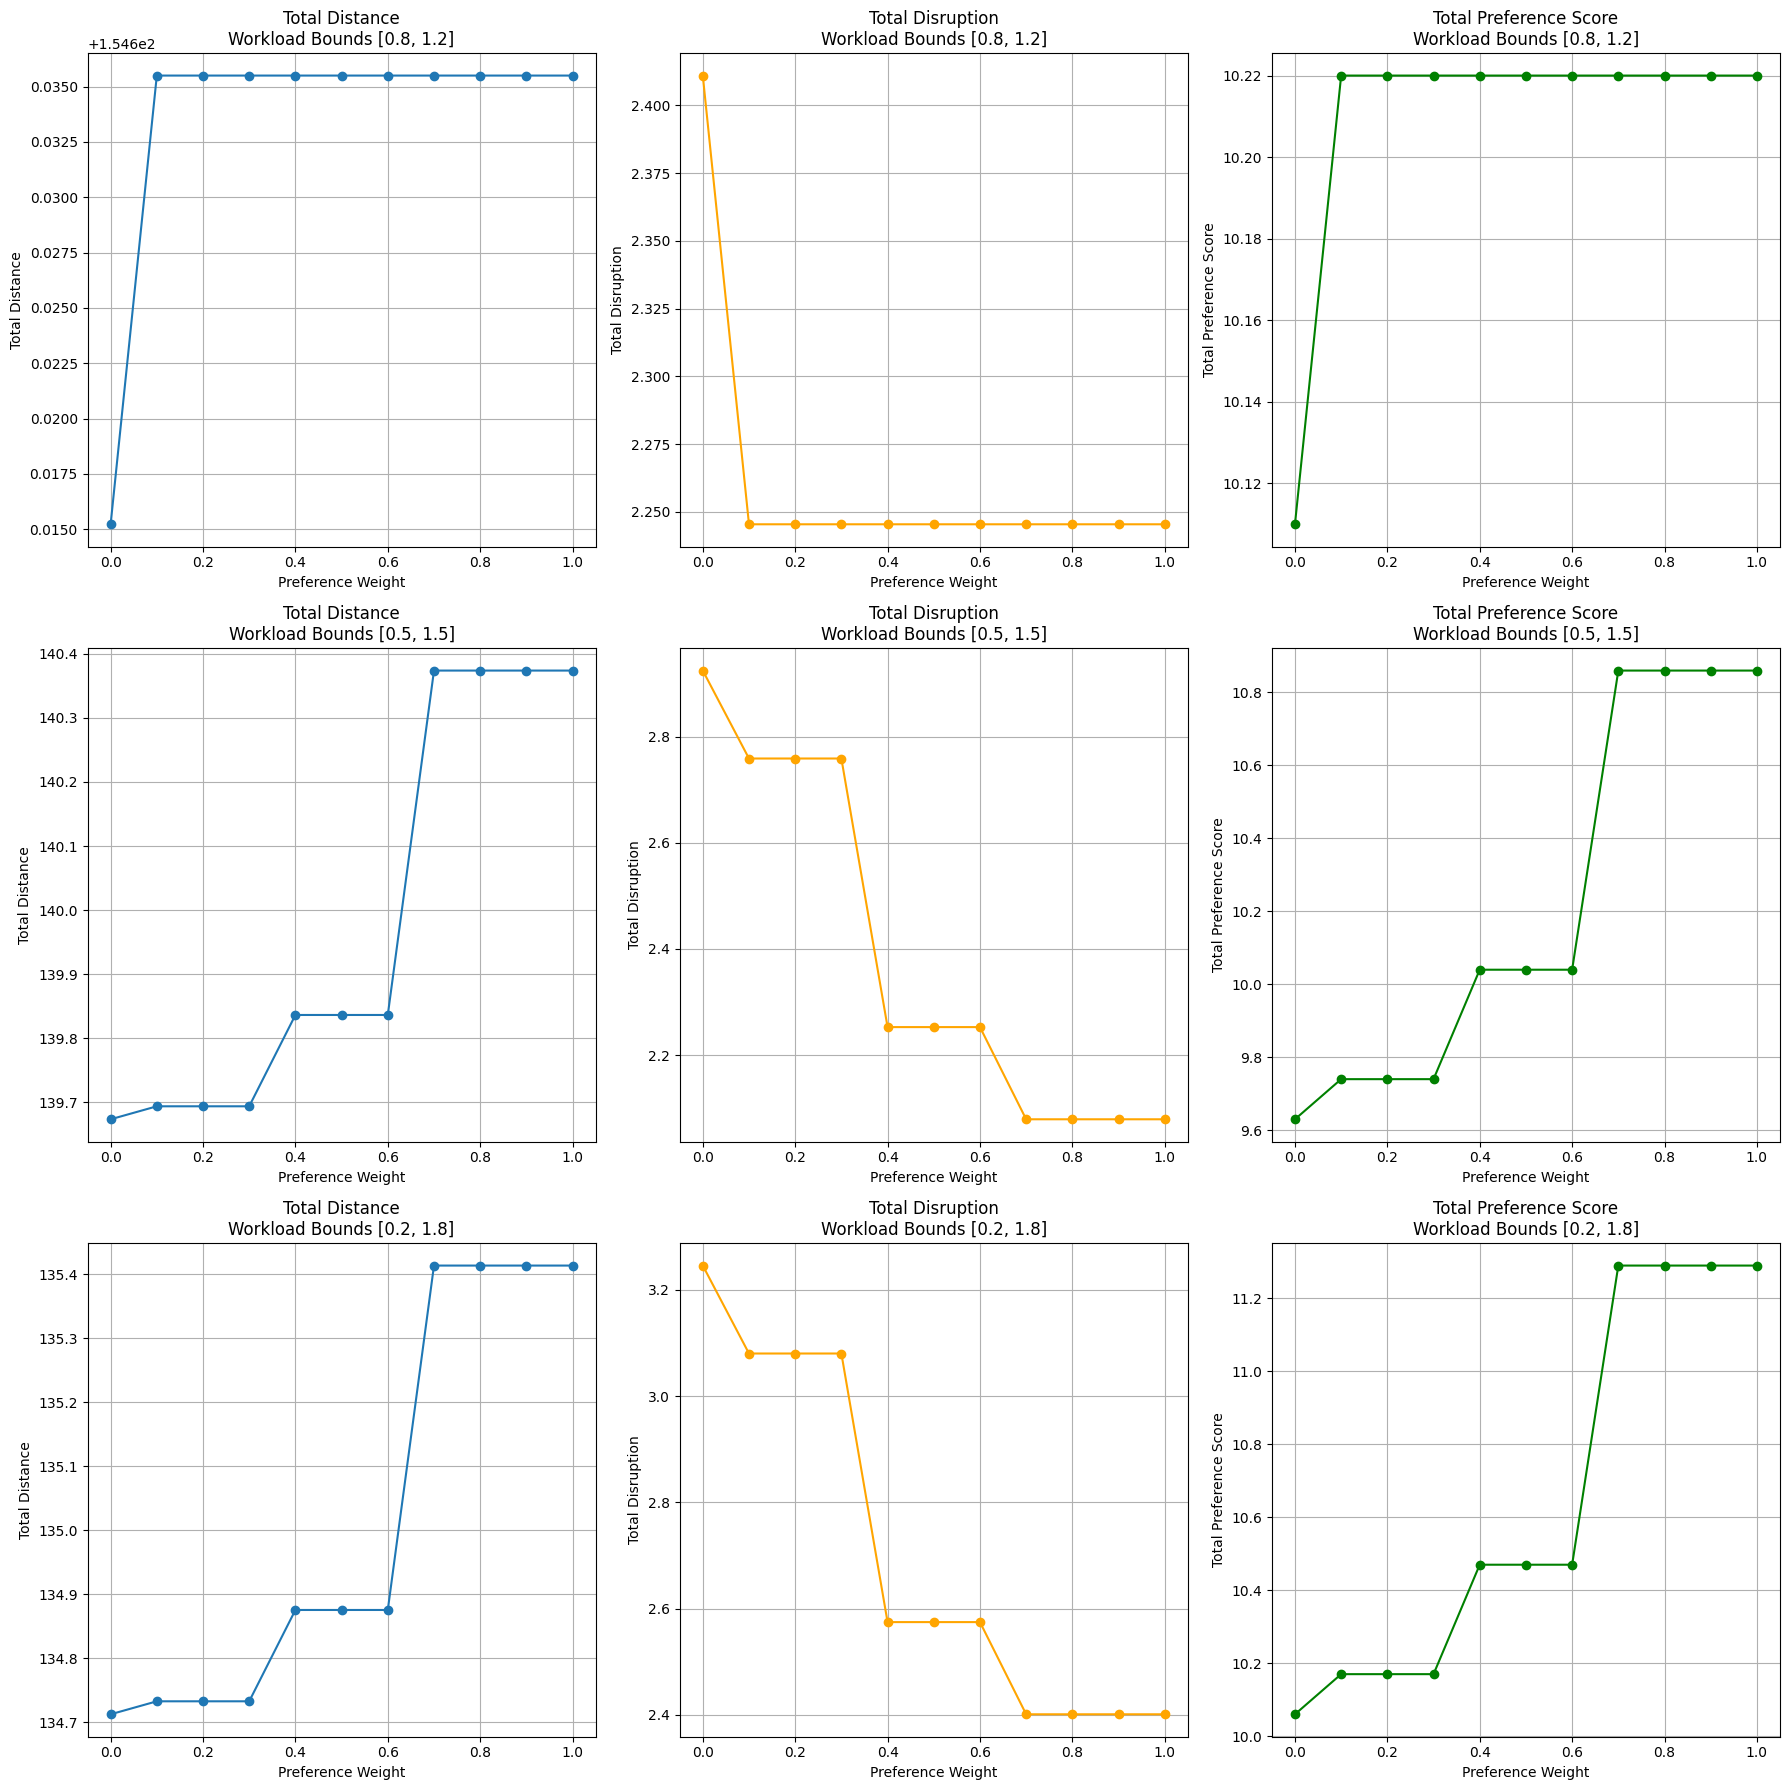


Workloads at Preference Weight 0.5 and Workload Bounds [0.8, 1.2]:
Workload of SR1: 0.9548
Workload of SR2: 1.1275
Workload of SR3: 1.1149
Workload of SR4: 0.8028

Assignment Matrix at Preference Weight 0.5 and Workload Bounds [0.8, 1.2]:
    SR1  SR2  SR3  SR4
1  -0.0  0.0  0.0  1.0
2   0.0  0.0  0.0  1.0
3   0.0  0.0  0.0  1.0
4   1.0  0.0  0.0  0.0
5   1.0  0.0  0.0  0.0
6   1.0  0.0  0.0  0.0
7   1.0  0.0  0.0  0.0
8   1.0  0.0  0.0  0.0
9   1.0  0.0  0.0  0.0
10  0.0 -0.0  1.0  0.0
11  0.0  1.0  0.0  0.0
12 -0.0  1.0  0.0  0.0
13  0.0  1.0  0.0  0.0
14  0.0  1.0  0.0  0.0
15  0.0  0.0  1.0  0.0
16  0.0  0.0  1.0  0.0
17  0.0  0.0  1.0  0.0
18  0.0  1.0  0.0  0.0
19  1.0  0.0  0.0  0.0
20  1.0  0.0  0.0  0.0
21  0.0  0.0  0.0  1.0
22  0.0  0.0  0.0  1.0


In [66]:
# Define the range of preference weights to test
preference_weights = np.linspace(0, 1, 11)  # From 0.0 to 1.0 in steps of 0.1

# Define a set of workload constraints to include
workload_constraints = [
    (0.8, 1.2),  # Narrow workload bounds
    (0.5, 1.5),  # Medium workload bounds
    (0.2, 1.8)   # Wide workload bounds
]

# Lists to store results
results = []

for workload_lower, workload_upper in workload_constraints:
    for pw in preference_weights:
        # Solve the optimization problem with varying preference weight and fixed workload constraints
        solution_data = solve_problem_with_preference_and_workload(
            preference_weight=pw,
            workload_lower=workload_lower,
            workload_upper=workload_upper,
            distance_weight=1.0,
            disruption_weight=0.1
        )

        if solution_data:
            results.append({
                'preference_weight': pw,
                'workload_lower': workload_lower,
                'workload_upper': workload_upper,
                'total_distance': solution_data['total_distance'],
                'total_disruption': solution_data['total_disruption'],
                'total_preference': solution_data['total_preference'],
                'workloads': solution_data['workloads'],
                'Xij': solution_data['Xij']
            })
        else:
            # In case no solution is found
            results.append({
                'preference_weight': pw,
                'workload_lower': workload_lower,
                'workload_upper': workload_upper,
                'total_distance': None,
                'total_disruption': None,
                'total_preference': None,
                'workloads': None,
                'Xij': None
            })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plotting side-by-side graphs for each workload constraint set
fig, axes = plt.subplots(len(workload_constraints), 3, figsize=(18, 6 * len(workload_constraints)))

for row, (workload_lower, workload_upper) in enumerate(workload_constraints):
    df = results_df[
        (results_df['workload_lower'] == workload_lower) &
        (results_df['workload_upper'] == workload_upper)
    ].dropna(subset=['total_distance'])

    # Plot Total Distance vs. Preference Weight
    axes[row, 0].plot(df['preference_weight'], df['total_distance'], marker='o')
    axes[row, 0].set_xlabel('Preference Weight')
    axes[row, 0].set_ylabel('Total Distance')
    axes[row, 0].set_title(f'Total Distance\nWorkload Bounds [{workload_lower}, {workload_upper}]')
    axes[row, 0].grid(True)

    # Plot Total Disruption vs. Preference Weight
    axes[row, 1].plot(df['preference_weight'], df['total_disruption'], marker='o', color='orange')
    axes[row, 1].set_xlabel('Preference Weight')
    axes[row, 1].set_ylabel('Total Disruption')
    axes[row, 1].set_title(f'Total Disruption\nWorkload Bounds [{workload_lower}, {workload_upper}]')
    axes[row, 1].grid(True)

    # Plot Total Preference Score vs. Preference Weight
    axes[row, 2].plot(df['preference_weight'], df['total_preference'], marker='o', color='green')
    axes[row, 2].set_xlabel('Preference Weight')
    axes[row, 2].set_ylabel('Total Preference Score')
    axes[row, 2].set_title(f'Total Preference Score\nWorkload Bounds [{workload_lower}, {workload_upper}]')
    axes[row, 2].grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()

# Optionally, display workloads and assignments for specific cases
# For example, display the workloads when preference_weight = 0.5 and workload bounds [0.8, 1.2]
specific_pw = 0.5
specific_bounds = (0.8, 1.2)
specific_solution = results_df[
    (results_df['preference_weight'] == specific_pw) &
    (results_df['workload_lower'] == specific_bounds[0]) &
    (results_df['workload_upper'] == specific_bounds[1])
].iloc[0]

if specific_solution['workloads'] is not None:
    print(f"\nWorkloads at Preference Weight {specific_pw} and Workload Bounds [{specific_bounds[0]}, {specific_bounds[1]}]:")
    for sr in range(num_sr):
        print(f"Workload of SR{sr+1}: {specific_solution['workloads'][sr]:.4f}")
else:
    print(f"\nNo solution found at Preference Weight {specific_pw} and Workload Bounds [{specific_bounds[0]}, {specific_bounds[1]}].")

# Display the assignment matrix
if specific_solution['Xij'] is not None:
    print(f"\nAssignment Matrix at Preference Weight {specific_pw} and Workload Bounds [{specific_bounds[0]}, {specific_bounds[1]}]:")
    print(specific_solution['Xij'])
else:
    print(f"\nNo assignment matrix available.")
